<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 最近鄰分類法(Nearest neighbors)
* 要有某種距離的概念
* 有個假設：距離較近的點彼此間會較類似

In [ ]:
# 計算票數的函式
from typing import List
from collections import Counter

def raw_majority_vote(labels:List[str])->str:
  votes = Counter(labels)
  winner,_ = votes.most_common(1)[0]
  return winner

In [ ]:
def major_votes(labels:List[str])->str:
  """假設labels中的資料已事先依據從進到遠的順序排序"""
    vote_conuts = Counter(labels)
    winner,winner_count = vote_conuts.most_common(1)[0]
    num_winners = len([count for countin vote_conuts.values() if count == winner_count])

    if num_winners == 1:
      return winner
    else:
      return major_votes(labels[:-1])

In [5]:

from typing import List

Vector = List[float]

def subtrate( v:Vector, w:Vector) -> Vector:
  assert len(v) == len(w) #兩個向量必須有相同的維度

  return [ v_i-w_i for v_i,w_i in zip(v,w)]

def magnitude(v:Vector)->float:
  return math.aqrt(sum_of_squares(v)) #math.sqrt 是計算平方根的一個函式

def distance(v:Vector,w:Vector) -> float:
  return magnitude(subtract(v,w))

In [7]:
from typing import NamedTuple

class LabeledPoint(NamedTuple):
  point:Vector
  label:str

def knn_classify(k:int,
         label_points:List[LabeledPoint],
         new_point:Vector) ->str:
  
  #針對這些已標示分類標籤的點，根據距離進到遠的順序進行排序
  by_distance = sorted(label_points,
             key=lambda lp:dustance(lp.point,new_point))
  
  #找出k個最近點所對應的分類標籤
  k_nearest_labels = [lp.label for lp in by_distance[k]]

  #讓他們進行投票
  return majority_vote(k_nearest_labels)

## 範例：鳶尾花資料集 
在機器學習方面常被運用的資料集。  
這個資料集包含150朵鳶尾花的測量值，每一朵花都有對應的萼片長度與寬度、以及所屬品種。


下載資料集

In [102]:
import csv
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

data=pd.read_csv(url, sep=',',header=None)

相應資料欄位如下：  
sepal_length, sepal_width, petal length, petal_width, class   
(花瓣長度,花辦寬度,等片長度,對片寬度,品種)

In [ ]:
# 進行預處理，將資料轉換為150個獨立陣列集合
preprocess_data = [list(data) for data in zip(list(data[0]),list(data[1]),list(data[2]),list(data[3]),list(data[4]))]
preprocess_data

In [111]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row:List[str])->LabeledPoint:
  """
  sepal_length, sepal_width, petal length, petal_width, class
  (花瓣長度,花辦寬度,等片長度,對片寬度,品種)
  """
  measurements = [float(value) for value in row[:-1]]
  
  #像"Iris-virginica"這樣的品種名稱，我們只取其中的"virginica"
  label = row[-1].split("-")[1]

  return LabeledPoint(measurements,label)

reader = data
iris_data = [parse_iris_row(row) for row in preprocess_data]

#我們只處理標有品種名稱的資料點，這樣才能順利畫出圖形
points_by_species:Dict[str,List[Vector]] = defaultdict(list)
for iris in iris_data:
  points_by_species[iris.label].append(iris.point)

### 圖 12-1 鳶尾花散點圖

IndexError: ignored

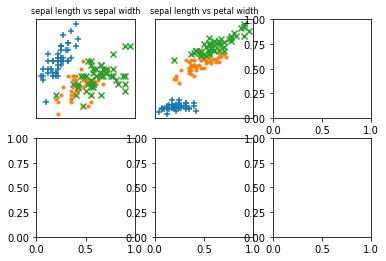

In [112]:
from matplotlib import pyplot as plt 
metrics = ['sepal length','sepal width','petal width']
pairs=[(i,j) for i in range(4) for j in range(4) if i<j]
marks = ["+",".","x"] #資料共有三種類別，故採用三種不同的標記符號

fig,ax = plt.subplots(2,3) #建立2x3的子圖展示框架

for row in range(2):
  for col in range(3):
    i,j = pairs[3*row+col]
    ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}",fontsize=8)
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

    for mark,(species,points) in zip(marks,points_by_species.items()):
      xs = [point[i] for point in points]
      ys = [point[j] for point in points]
      ax[row][col].scatter(xs,ys,marker=mark,label=species)

ax[-1][-1].legend(loc='lower right',prop={'size':6})
plt.show()